<img src='./img/header_placeholder.png' alt='Logo EU Copernicus ECMWF' align='right' width='100%'></img>

<br>

# CAMS Fire monitoring

### About

This notebook provides you a practical introduction to CAMS global atmospheric forecasts and shows you how you can use the variable `Organic Matter Aerosol Optical Depth at 550nm` for wildfire monitoring. The workflow shows the Organic Matter Aerosol Optical Depth at 550nm that originated from the devastating wildfires occurring in the USA during August 2021.

The notebook has the following outline:

* [1 - Unzip the downloaded data file](#unzip_fire)
* [2 - Load and browse CAMS global atmospheric composition forecast of Organic Matter Aerosol Optical Depth at 550nm](#load_fire)
* [3 - Visualize the forecast of Organic Matter AOD at 550nm](#visualize_fire)
* [4 - Animate daily 6-hourly Organic Matter AOD at 550nm forecast over the USA from 1 to 8 August 2021](#animate_fire)

### Data

This notebook introduces you to the [CAMS global atmospheric forecasts](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts?tab=overview). The data has the following specifications:

> **Data**: `CAMS global atmospheric forecasts` <br>
> **Temporal coverage**: `6-hourly forecasts for the period from 1 to 8 August 2021` <br>
> **Spatial coverage**: `Geographic subset of the USA` <br>
> **Format**: `zipped NetCDF`<br>
> **Retrieve request**: [CDS API request](./200_atmosphere_data_store_intro.ipynb#era5_monthly)

Get [here](./201_cams_data_intro.ipynb) more information about CAMS data in general.

### How to access the notebook
* via [nbviewer](https://github.com/ecmwf-projects/copernicus-training/blob/master/111_c3s_climatologies_anomalies.ipynb): view a static version of the notebook 
* via [Binder](https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training/HEAD?urlpath=lab/tree/111_c3s_climatologies_anomalies.ipynb): run, execute and modify the notebook

### Further resources

* [New decade brings reference period change for climate data](https://climate.copernicus.eu/new-decade-reference-period-change-climate-data)
* [2020 closes a decade of exceptional heat](https://public.wmo.int/en/media/news/2020-closes-decade-of-exceptional-heat)
* [Copernicus: 2020 warmest year on record for Europe; globally, 2020 ties with 2016 for warmest year recorded](https://climate.copernicus.eu/2020-warmest-year-record-europe-globally-2020-ties-2016-warmest-year-recorded)

<br>

<hr>

### Load libraries

In [14]:
# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib import animation

from IPython.display import HTML

import time

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

from IPython.display import clear_output
clear_output(wait=True)

### Load helper function

In [9]:
%run ./functions.ipynb

<hr>

### <a id='unzip_fire'></a> 1. Unzip the downloaded data file

CAMS global atmospheric composition forecasts can be retrieved either in `GRIB` or in a `zipped NetCDF`. Above, we requested the data in a zipped NetCDF and for this reason, we have to unzip the file before we can open it. You can unzip `zip archives` in Python with the Python package `zipfile` and the function `extractall()`.

In [3]:
import zipfile
with zipfile.ZipFile('./data/cams/2021-08_NAmerica_organicMatterAOD.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/cams/202108/')

<br>

### <a id='load_fire'></a> 2. Load and browse CAMS global atmospheric composition forecast of Organic Matter Aerosol Optical Depth at 550nm

Once the data has been extracted from the zip archive, you can load the NetCDF file with the Python library [xarray](http://xarray.pydata.org/en/stable/) and the function `open_dataset()`. The function loads a `xarray.Dataset`, which is a collection of one or more data variables that share the same dimensions. You see that the data file has three dimensions, `latitude`, `longitude` and `time` and one variable, `omaod550`. 

In [4]:
ds = xr.open_dataset('./data/cams/202108/data.nc')
ds

<xarray.Dataset>
Dimensions:    (latitude: 138, longitude: 251, time: 32)
Coordinates:
  * longitude  (longitude) float32 -150.0 -149.6 -149.2 ... -50.8 -50.4 -50.0
  * latitude   (latitude) float32 79.8 79.4 79.0 78.6 ... 26.2 25.8 25.4 25.0
  * time       (time) datetime64[ns] 2021-08-01 ... 2021-08-08T18:00:00
Data variables:
    omaod550   (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-08-16 16:14:32 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

Let us now extract from the Dataset above the data variable `omaod550` as `xarray.DataArray`. You can load a data array from a xarray.Dataset by specifying the name of the variable (`omaod550`) in square brackets.
While an xarray **dataset** may contain multiple variables, an xarray **data array** holds a single multi-dimensional variable and its coordinates. Below you see that the variable `omaod550` represents Organic Matter Aerosol Optical Depth at 550 nm.

In [5]:
omaod550 = ds['omaod550']
omaod550

<xarray.DataArray 'omaod550' (time: 32, latitude: 138, longitude: 251)>
[1108416 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -150.0 -149.6 -149.2 ... -50.8 -50.4 -50.0
  * latitude   (latitude) float32 79.8 79.4 79.0 78.6 ... 26.2 25.8 25.4 25.0
  * time       (time) datetime64[ns] 2021-08-01 ... 2021-08-08T18:00:00
Attributes:
    units:      ~
    long_name:  Organic Matter Aerosol Optical Depth at 550nm

<br>

Let us define variables for the two attributes `units` and `long_name`, which we can use during the visulisation of the data.

In [6]:
omaod550_unit = omaod550.units
omaod550_long_name = omaod550.long_name

<br>

### <a id='visualize_fire'></a>3. Visualize the forecast of Organic Matter AOD at 550nm

And now we can plot the `Organic Matter AOD at 550 nm`. The visualisation code below can be divided in five main parts:
* **Initiate a matplotlib figure:** with `plt.figure()` and an axes object
* **Plotting function**: plot the data array with the matplotlib function `pcolormesh()`
* **Define a geographic extent of the map**: use the minimum and maximum latitude and longitude bounds of the data
* **Add additional mapping features**: such as coastlines, grid or a colorbar
* **Set a title of the plot**: you can combine the `species name` and `time` information for the title

Text(0.5, 1.0, 'Organic Matter Aerosol Optical Depth at 550nm over USA - 2021-08-06T00:00:00.000000000\n')

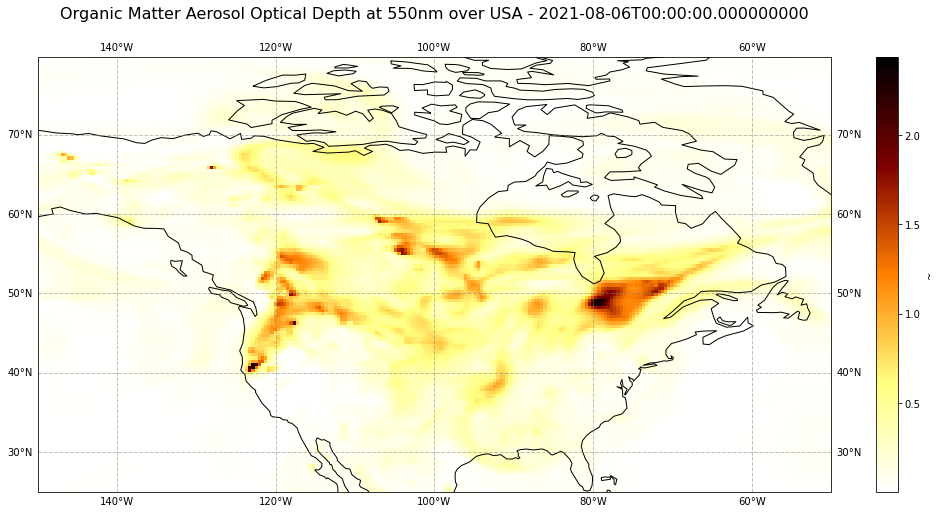

In [7]:
# Index of forecast time step
time_index = 20

# Initiate a matplotlib figure
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

# Plotting function with pcolormesh
im = plt.pcolormesh(omaod550['longitude'].values, omaod550['latitude'].values,
                    omaod550[time_index,:,:], cmap='afmhot_r', transform=ccrs.PlateCarree())

# Define geographic extent of the map
ax.set_extent([omaod550.longitude.min(),omaod550.longitude.max(),omaod550.latitude.min(),omaod550.latitude.max()], crs=ccrs.PlateCarree())

# Add additional features such as coastlines, grid and colorbar
ax.coastlines(color='black')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
cbar = plt.colorbar(im,fraction=0.046, pad=0.05)
cbar.set_label(omaod550_unit)

# Set the title of the plot
ax.set_title(omaod550_long_name + ' over USA - ' + str(omaod550.time[time_index].values)+'\n', fontsize=16)

<br>

### <a id='animate_fire'></a>4. Animate daily 6-hourly Organic Matter AOD at 550nm forecast over the USA from 1 to 8 August 2021

In the last step, you can animate the `organic matter AOD at 550nm` in order to see how the trace gas develops over a period of eight days, from 1 to 8 August 2021.
You can do animations with matplotlib's function `animation`. Jupyter's function `HTML` can then be used to display HTML and video content.

The animation function consists of 4 parts:
- **Setting the initial state:**<br>
 Here, you define the general plot your animation shall use to initialise the animation. You can also define the number of frames (time steps) your animation shall have.
 
 
- **Functions to animate:**<br>
 An animation consists of three functions: `draw()`, `init()` and `animate()`. `draw()` is the function where individual frames are passed on and the figure is returned as image. In this example, the function redraws the plot for each time step. `init()` returns the figure you defined for the initial state. `animate()` returns the `draw()` function and animates the function over the given number of frames (time steps).
 
 
- **Create a `animate.FuncAnimation` object:** <br>
 The functions defined before are now combined to build an `animate.FuncAnimation` object.
 
 
- **Play the animation as video:**<br>
 As a final step, you can integrate the animation into the notebook with the `HTML` class. You take the generate animation object and convert it to a HTML5 video with the `to_html5_video` function

In [17]:
# Setting the initial state:
# 1. Define figure for initial plot
fig, ax = visualize_pcolormesh(data_array=omaod550[0,:,:],
                               longitude=omaod550.longitude, 
                               latitude=omaod550.latitude,
                               projection=ccrs.PlateCarree(), 
                               color_scale='afmhot_r', 
                               unit=omaod550_unit,
                               long_name=omaod550_long_name + ' '+ str(omaod550.time[0].data),
                               vmin=0,
                               vmax=2, 
                               lonmin=omaod550.longitude.min(), 
                               lonmax=omaod550.longitude.max(), 
                               latmin=omaod550.latitude.min(), 
                               latmax=omaod550.latitude.max(),
                               set_global=False)

frames = 31

def draw(i):
    img = plt.pcolormesh(omaod550.longitude, 
                         omaod550.latitude, 
                         omaod550[i,:,:], 
                         cmap='afmhot_r', 
                         transform=ccrs.PlateCarree(),
                         vmin=0,
                         vmax=2,
                         shading='auto')
    
    ax.set_title(omaod550_long_name + ' '+ str(omaod550.time[i].data), fontsize=20, pad=20.0)
    return img


def init():
    return fig


def animate(i):
    return draw(i)

ani = animation.FuncAnimation(fig, animate, frames, interval=800, blit=False,
                              init_func=init, repeat=True)

HTML(ani.to_html5_video())
plt.close(fig)

<br>

**Play the animation video as HTML5 video**

In [18]:
HTML(ani.to_html5_video())

<br>

The animation clearly shows the high values of organic matter aerosol optical depth originating from the many different wildfires burning across North America in this period. This includes the Dixie fire, which, by August 6, had grown to become the largest single (i.e. non-complex) wildfire in California's history, and the second-largest wildfire overall. 

The animation also shows these high values crossing the continent to the east coast where it strongly affected local air quality.

<br>

<hr>

<p><img src='./img/copernicus_logo.png' align='right' alt='Logo EU Copernicus' width='20%'></img></p>
<br><br><br><br><br>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>

<br>

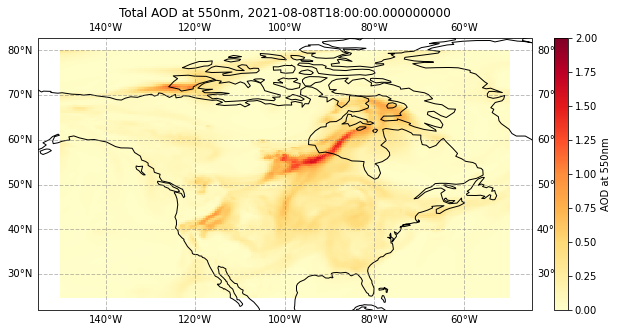

In [18]:
n = omaod550.time.shape[0] # Number of frames in animation (= number of time-steps)

for i in range(n):
    fig = plt.figure(figsize=(10, 5)) # Define the figure and specify size
    ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree()) # Specify plot area & projectionax.set_extent([-150,-50,25,80], crs=ccrs.PlateCarree()) # Specify geographical extent
    
    ax.coastlines(color='black') # Add coastlines
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') # Add lat/lon grid
    ax.set_title(f'Total AOD at 550nm, {omaod550.time[i].values}', fontsize=12) # Set figure title
    
    im = plt.pcolormesh(omaod550.longitude, omaod550.latitude, omaod550[i,:,:], cmap='YlOrRd', vmin=0, vmax=2) # Plot the data, iterating over time
    cbar = plt.colorbar(im,fraction=0.046, pad=0.04) # Specify the colourbar
    cbar.set_label('AOD at 550nm') # Define the colourbar label
    plt.show() # Display the figure
    time.sleep(0.01) # Specify time delay for each iteration (frame) of the animation
    clear_output(wait=True) # Clear the output (figure) before the next iteration (frame) of the animation